<a href="https://colab.research.google.com/github/LordRelentless/NGFTSimulations/blob/main/5_3_1_Simulation_Informational_Curvature_in_Qubit_Systems_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
using Pkg
Pkg.add("Yao")          # Quantum simulation engine
Pkg.add("Plots")        # Visualization
Pkg.add("Random")
Pkg.add("StatsBase")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed TupleTools ──────────────── v1.6.0
   Installed YaoAPI ──────────────────── v0.4.8
   Installed SymEngine_jll ───────────── v0.12.0+0
   Installed YaoPlots ────────────────── v0.9.4
   Installed BatchedRoutines ─────────── v0.2.2
   Installed BitBasis ────────────────── v0.9.10
   Installed Rsvg ────────────────────── v1.0.0
   Installed TreeWidthSolver ─────────── v0.3.5
   Installed ArnoldiMethod ───────────── v0.4.0
   Installed YaoToEinsum ─────────────── v0.2.5
   Installed LegibleLambdas ──────────── v0.3.0
   Installed VectorInterface ─────────── v0.5.0
   Installed Graphics ────────────────── v1.1.3
   Installed KrylovKit ───────────────── v0.9.5
   Installed Graphs ──────────────────── v1.13.0
   Installed MPC_jll ─────────────────── v1.3.1+0
   Installed MLStyle ─────────────────── v0.4.17
   Installed YaoSym ──────────────────── v0.6.9
   Installed YaoBlocks ────────────

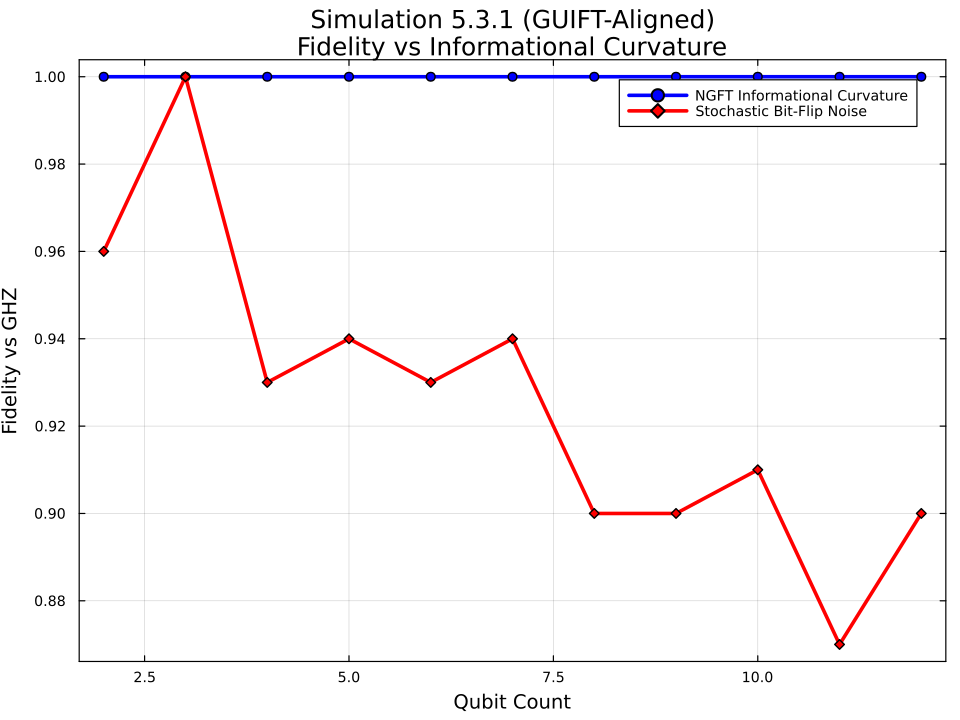

In [9]:
using Yao
using Plots
using Random
using Statistics

# === NGFT Constants ===
const α_U = 1.0e-21     # Arbitrary scale, can be tuned dimensionally
const k = 3.0           # S_M / S_I ratio: mass entropy to info entropy

# === Simulation Parameters ===
max_qubits = 12
repeats = 100
noise_prob = 0.01

# === GUIFT Curvature Generator ===
function informational_curvature_operator(n::Int)
    phases = [α_U * (i^2) / (n^2 * k) for i in 1:n]  # Approximate I_i from index symmetry
    return chain([put(n, i => rot(Z, phases[i])) for i in 1:n]...)
end

# === GHZ Generator (Informationally Coherent Register) ===
function ghz_circuit(n::Int)
    return chain(n, [
        put(n, 1 => H),
        chain([control(i, i+1 => X) for i in 1:n-1]...)
    ])
end

# === Decoherence Channel ===
function apply_decoherence(qreg::AbstractRegister, prob::Float64)
    noisy = deepcopy(qreg)
    for i in 1:nqubits(noisy)
        if rand() < prob
            noisy = apply!(noisy, put(nqubits(noisy), i => X))
        end
    end
    return noisy
end

# === Fidelity Function ===
fidelity(q₁, q₂) = abs(dot(statevec(q₁), statevec(q₂)))^2

# === Core Experiment ===
function run_ngft_experiment()
    sizes = 2:max_qubits
    NGFT_fid, noise_fid = Float64[], Float64[]

    for n in sizes
        fid_ngft, fid_noise = Float64[], Float64[]
        ghz = ghz_circuit(n)
        for _ in 1:repeats
            ψ₀ = zero_state(n)
            ψ_ref = apply!(deepcopy(ψ₀), ghz)

            # NGFT informational curvature (deterministic)
            ψ_curved = deepcopy(ψ_ref)
            ψ_curved = apply!(ψ_curved, informational_curvature_operator(n))
            push!(fid_ngft, fidelity(ψ_ref, ψ_curved))

            # Random decoherence
            ψ_noisy = apply_decoherence(deepcopy(ψ_ref), noise_prob)
            push!(fid_noise, fidelity(ψ_ref, ψ_noisy))
        end

        push!(NGFT_fid, mean(fid_ngft))
        push!(noise_fid, mean(fid_noise))
    end

    return sizes, NGFT_fid, noise_fid
end

# === Run & Plot with Full Title Visible ===
sizes, NGFT, noisy = run_ngft_experiment()

plot(
    sizes, NGFT,
    label = "NGFT Informational Curvature",
    lw = 3, color = :blue, marker = :circle,
    xlabel = "Qubit Count",
    ylabel = "Fidelity vs GHZ",
    title = "Simulation 5.3.1 (GUIFT-Aligned)\nFidelity vs Informational Curvature",
    legend = :topright,
    size = (800, 600),
    dpi = 120,
    framestyle = :box
)

plot!(
    sizes, noisy,
    label = "Stochastic Bit-Flip Noise",
    lw = 3, color = :red, marker = :diamond
)